In [1]:
%cd ..

/home/enes/dev/maskpredformer


In [2]:
import torch 
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import os 
from torchvision import transforms
import tqdm
import torch

from torchmetrics import JaccardIndex
from lightning import seed_everything

from maskpredformer.scheduled_sampling_trainer import MaskSimVPScheduledSamplingModule
from maskpredformer.vis_utils import show_video_line

seed_everything(0)
torch.backends.cudnn.deterministic = True

Seed set to 0


In [3]:
ckpt_path = "checkpoints/simvp_ss_epoch=2-valid_last_frame_iou=0.456.ckpt"
module = MaskSimVPScheduledSamplingModule.load_from_checkpoint(ckpt_path, use_gt_data=True, unlabeled=False, load_datasets=False)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class WenmaSet(Dataset):
    def __init__(self, data_path, data_type, transform=None):
        self.data_path = data_path
        self.data_type = data_type
        self.transform = transform

        if (
            self.data_type == "train"
            or self.data_type == "val"
            or self.data_type == "unlabeled"
        ):
            self.num_frames = 22

        else:
            self.num_frames = 11

    def __getitem__(self, ind):
        images = []
        masks = []

        if "train" in self.data_type:
            ind = ind

        elif "val" in self.data_type:
            ind = ind + 1000

        elif "unlabeled" in self.data_type:
            ind = ind + 2000

        elif "hidden" in self.data_type:
            ind = ind + 15000

        video_path = os.path.join(self.data_path, "video_{}".format(ind))

        if "hidden" in self.data_type or "unlabeled" in self.data_type:
            mask_path = None

        else:
            mask_path = os.path.join(video_path, "mask.npy")

        for frame in range(self.num_frames):
            image_path = os.path.join(video_path, "image_{}.png".format(frame))
            image = np.array(Image.open(image_path))
            if self.transform:
                image = self.transform(image)
            images.append(image)
            if mask_path != None:
                if "prediction" in self.data_type:
                    mask = np.load(mask_path)[frame + 11]
                else:
                    mask = np.load(mask_path)[frame]
            else:
                mask = torch.zeros((160, 240))
            masks.append(mask)

        return images, masks

    def __len__(self):
        return len(os.listdir(self.data_path))

In [6]:
unet_model = torch.jit.load('checkpoints/unet9.pt').to(device)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),           
    transforms.Resize((160, 240)),          
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
           
])
data_path = "data/Dataset_Student/"
data_type = "val"

dataset= WenmaSet(data_path = data_path + data_type,
                  data_type = data_type,
                  transform = transform)

In [8]:
def get_mask_predictions_and_target(i):
    imgs, masks = dataset[i]
    mask_predictions = []
    for i in range(22):
        image = imgs[i].unsqueeze(0).to(device)
        mask_prediction = unet_model(image)
        mask_predictions.append(mask_prediction.squeeze(0))
    mask_predictions = [torch.argmax(pred, dim=0).detach().cpu() for pred in mask_predictions]
    mask_predictions_input = mask_predictions[:11]
    targets = masks[11:]
    return torch.stack(mask_predictions_input), torch.from_numpy(np.stack(targets))

In [9]:
inputs, targets = get_mask_predictions_and_target(3)

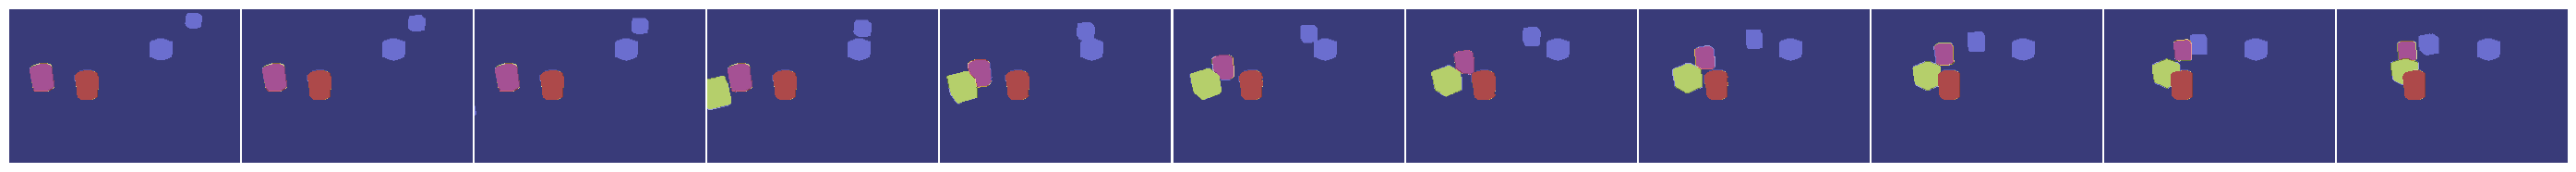

In [10]:
show_video_line(inputs, 11)

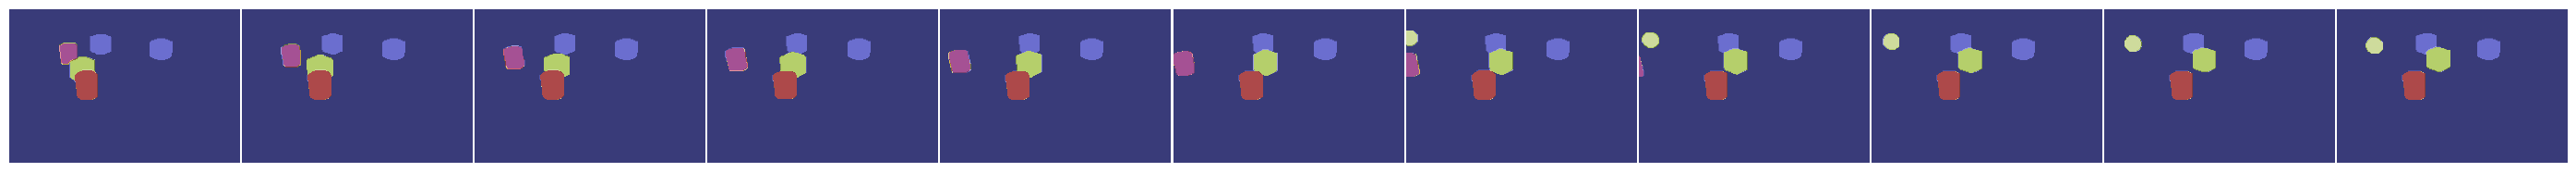

In [11]:
show_video_line(targets, 11)

In [12]:
@torch.no_grad()
def get_predictions(module, x):
    x = x.unsqueeze(0).to(module.device)
    cur_seq = module.sample_autoregressive(x, 11)
    y_hat = cur_seq.squeeze(0).cpu()
    return y_hat

In [13]:
y_hat = get_predictions(module, inputs)

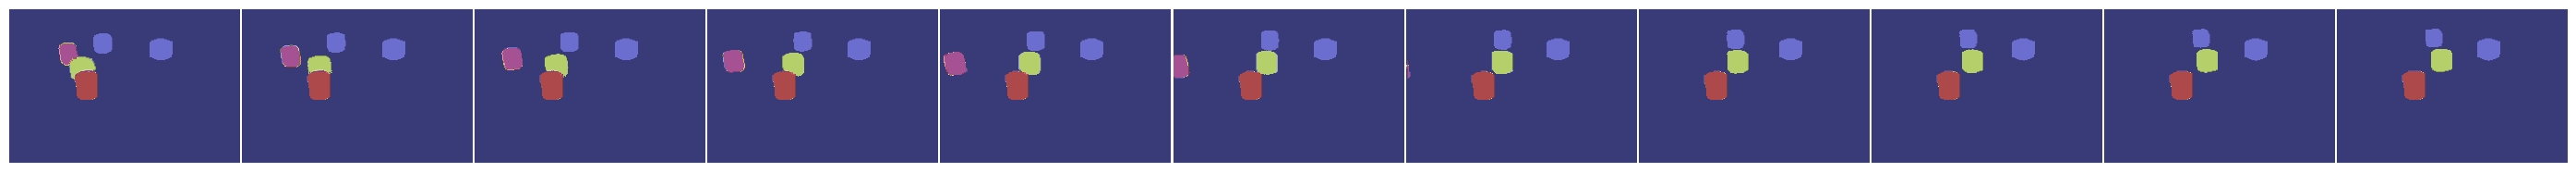

In [14]:
show_video_line(y_hat, 11)

## Jaccard IoU calculation

In [15]:
jaccard = JaccardIndex(task='multiclass', num_classes=49)

In [16]:
jaccard(y_hat[-1], targets[-1])

tensor(0.6579)

Calculate the Jaccard IoU for all data in validation set.

In [17]:
all_yhat = []
all_targets = []
for i in tqdm.tqdm(range(len(dataset))):
    inputs, targets = get_mask_predictions_and_target(i)
    y_hat = get_predictions(module, inputs)
    all_yhat.append(y_hat[-1].cpu())
    all_targets.append(targets[-1].cpu())

100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


In [22]:
jaccard(torch.stack(all_yhat), torch.stack(all_targets))

tensor(0.4439)